## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [13]:
from google.colab import drive
drive.mount('/content/drive/')

file_path = '/content/drive/MyDrive/coco/coco_captions.npy'

import numpy as np

caption_embeddings= np.load(file_path)

print('Caption embeddings',caption_embeddings.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Caption embeddings (40504, 5, 512)


In [14]:
file_path = '/content/drive/MyDrive/coco/coco_imgs.npy'

import numpy as np

image_embeddings= np.load(file_path)

In [11]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO

but Gdown can't. Please check connections and permissions.


In [3]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=ae556bd4-bfd9-43f0-a1de-2e149dbb1a56
To: /content/coco_captions.npy
100% 415M/415M [00:03<00:00, 133MB/s]


In [3]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [15]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from nltk.translate import bleu_score
import faiss
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from nltk.translate.bleu_score import sentence_bleu

In [16]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [17]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [18]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [19]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/coco_captions.npy'

In [9]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/coco_imgs.npy'

In [21]:
# Load embeddings
# caption_embeddings = np.load('/content/coco_captions.npy')
# image_embeddings = np.load('/content/coco_imgs.npy')

# Splitting the data based on indices
indices = np.arange(len(image_embeddings))
train_indices, test_indices = train_test_split(indices, test_size=5, random_state=42)
train_caption_embeddings = caption_embeddings[train_indices]
train_image_embeddings = image_embeddings[train_indices]
test_caption_embeddings = caption_embeddings[test_indices]
test_image_embeddings = image_embeddings[test_indices]

real_captions = []
for i in test_indices:
  real_captions.append(captions_np[i])

# Create FAISS index for images
index = faiss.IndexFlatIP(train_image_embeddings.shape[1])
index.add(train_image_embeddings)

# Number of nearest neighbors
k_values = [5, 10, 15]

# Compute k nearest neighbors for each test image
results = {}
for k in k_values:
    D, I = index.search(test_image_embeddings, k)
    results[k] = {'D': D, 'I': I}

# Compute query vectors
def compute_query_vector(image_index, I, D, caption_embeddings):
    neighbors_indices = I[image_index][1:]
    neighbors_distances = D[image_index][1:]
    similarity_scores = 1 / (1 + neighbors_distances)
    weighted_sum = np.zeros(512)
    total_weight = 0

    for idx, weight in zip(neighbors_indices, similarity_scores):
        neighbor_captions = caption_embeddings[idx]
        weighted_caption_mean = np.mean(neighbor_captions, axis=0)
        weighted_sum += weight * weighted_caption_mean
        total_weight += weight

    query_vector = weighted_sum / total_weight if total_weight > 0 else weighted_sum
    return query_vector

test_query_vectors = np.array([compute_query_vector(i, results[k]['I'], results[k]['D'], caption_embeddings) for i in range(len(test_image_embeddings))])


if len(train_caption_embeddings.shape) == 3:
    train_caption_embeddings = train_caption_embeddings.reshape(-1, train_caption_embeddings.shape[2])
train_caption_index = faiss.IndexFlatIP(train_caption_embeddings.shape[1])
train_caption_index.add(train_caption_embeddings)


_, closest_train_indices = train_caption_index.search(test_query_vectors, 1)


predicted_captions = {}
for k in k_values:
    predicted_captions[k] = [captions_flat[idx] for idx in closest_train_indices.flatten()]


def accuracy_v2(predict, real):
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre),weights=[1,0,0,0])
        accuracy += score
    return accuracy / len(predict)

for k, predictions in predicted_captions.items():
    print(f'Accuracy for k={k}: {accuracy_v2(predictions, real_captions)}')

print(f'Predicted Captions: {predictions}')

Accuracy for k=5: 0.42372930679375587
Accuracy for k=10: 0.42372930679375587
Accuracy for k=15: 0.42372930679375587
Predicted Captions: ['a train on train tracks with a sky back ground', 'A sign for a beauty store in a city. ', 'a woman on a train holds up her camera to take a picture of something outside the window', 'A man riding a surfboard on top of a wave in the ocean.', 'Parrot on glove of owner in darkened room']


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

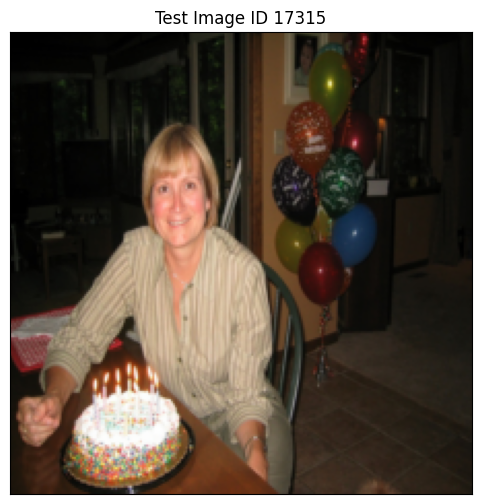

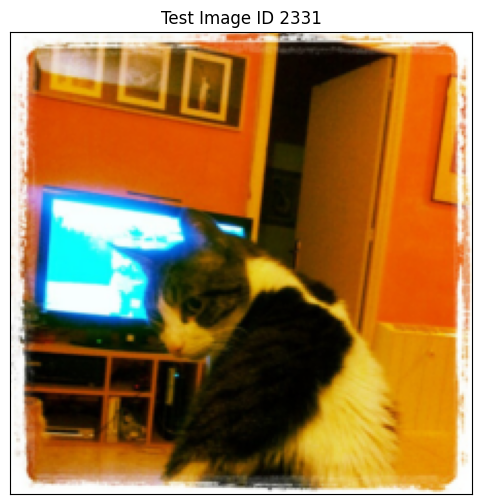

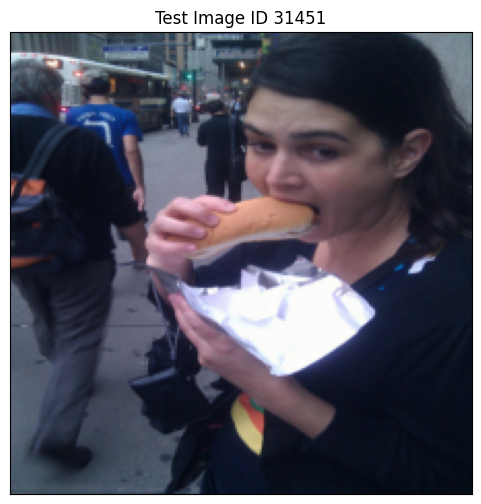

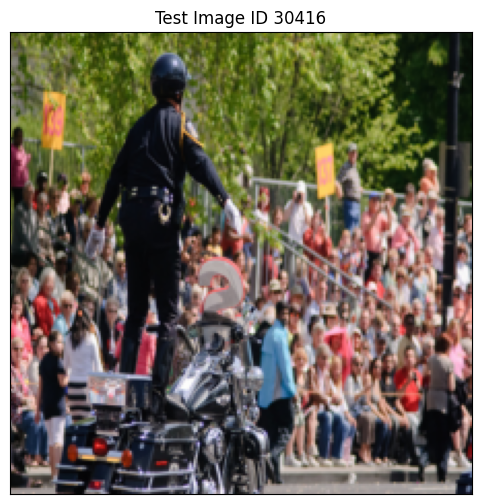

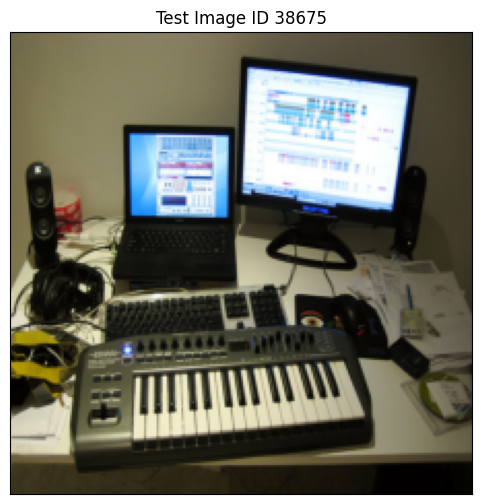

In [22]:
def show_image(dataset, idx):
      image, _ = coco_dset[idx]

      img = image.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      img = std * img + mean
      img = np.clip(img, 0, 1)

      plt.figure(figsize=(6, 6))
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

      plt.title(f"Test Image ID {idx}")

      plt.show()


for idx in test_indices:
    show_image(coco_dset, idx)